# Set Environments

In [31]:
# set GPU
# torch 보다 먼저 import 해야 아래 사항이 적용된다
import os, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU 1 to use
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [32]:
import torch
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from IIP_STFT import IIPSTFT
import librosa 
import IPython.display as ipd

# Load audio file
data_path = '/home/nas3/DB/Audioset/Fast-Audioset-Download/wavs/balanced_train/'
audio_path = glob.glob(os.path.join(data_path, '**/*.m4a'))

y, sr = librosa.load(audio_path[4], sr=16000, mono=True)  # Load the file at 16 kHz

## 1. Get spectrograms

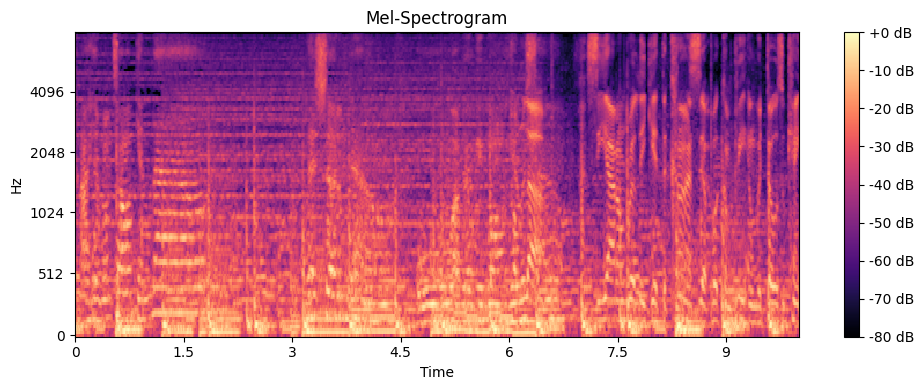

In [33]:
# Generate the Mel-spectrogram
STFT_init = {
    'nWin': 1024,
    'nfft': 1024,
    'nShift': 256,
    'sr':16000,
    'n_mels': 128
}

spectrogram = librosa.feature.melspectrogram(y=y, sr=STFT_init['sr'], n_fft=STFT_init['nfft'], hop_length=STFT_init['nShift'], n_mels=STFT_init['n_mels'])

# Convert to log scale
log_mel_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

# Visualize the spectrogram (Optional)
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=STFT_init['sr'], win_length=STFT_init['nWin'], hop_length=STFT_init['nShift'], x_axis='time', y_axis='mel')
plt.title('Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
ipd.Audio(y, rate=16000)

## 2. Prepare Spectrogram for model

In [34]:
import torch.nn.functional as F

spec_tensor = torch.tensor(log_mel_spectrogram) # Convert spectrogram to tensor
spec_tensor = spec_tensor.unsqueeze(0).unsqueeze(0)  # Add batch dimension and channel dimension (since it's mono, channel=1) -> Shape: (1, 1, n_mels, time_frames)
spec_tensor = spec_tensor.float() # Ensure it's a FloatTensor (for compatibility with PyTorch model)

# Padding
h_pad = (16 - spec_tensor.shape[2] % 16) % 16
w_pad = (16 - spec_tensor.shape[3] % 16) % 16
spec_tensor = F.pad(spec_tensor, (0, w_pad, 0, h_pad), mode='constant', value=0)

print(spec_tensor.shape)  # Should be (1, 1, n_mels, time_frames)

torch.Size([1, 1, 128, 640])


In [35]:
from MLPMixer_audio import MLPMixer
# from model import MLPMixer

In [36]:
(spec_tensor.shape[2] // 16) * (spec_tensor.shape[3] // 16)

320

In [37]:
model = MLPMixer(
    patch_size=16,
    freq_bins = 128,  # number of frequency bins in the spectrogram
    time_frames = 640,
    num_patches=(spec_tensor.shape[2] // 16) * (spec_tensor.shape[3] // 16),  # 16x16 패치
    # input_channels=1,  # Mel-spectrogram은 1개의 채널
    hidden_dim=768,
    token_mixing_dim=384,
    channel_mixing_dim=768,
    num_of_mlp_blocks=12,
    num_classes=10,  # 예: 10개 클래스로 분류하는 경우

)

# 모델에서 forward 함수 실행
output = model(spec_tensor)

# 결과 출력
print(output)

tensor([[ 3.0952e-01, -4.8985e-01, -6.6865e-02, -9.0787e-01, -3.3771e-01,
         -6.8733e-04, -4.4592e-01, -7.2785e-01,  6.2699e-01, -5.1209e-01]],
       grad_fn=<AddmmBackward0>)


In [38]:
from torchsummary import summary
# summary(model, input_size=(1, 128, 640))
print(model)

MLPMixer(
  (projection): Linear(in_features=256, out_features=768, bias=True)
  (mlp_blocks): ModuleList(
    (0): MLPBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (gelu): GELU()
      (W1): Linear(in_features=320, out_features=384, bias=True)
      (W2): Linear(in_features=384, out_features=320, bias=True)
      (W3): Linear(in_features=768, out_features=768, bias=True)
      (W4): Linear(in_features=768, out_features=768, bias=True)
      (cross_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
    )
    (1): MLPBlock(
      (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (gelu): GELU()
      (W1): Linear(in_features=320, out_features=384, bias=True)
      (W2): Linear(in_features=

In [29]:
import os
import json
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
import librosa
import torchaudio.transforms as T
from torch.utils.data import ConcatDataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from MLPMixer_audio import MLPMixer  # MLP-Mixer for Audio model

import warnings

# librosa의 FutureWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")

# PySoundFile 관련 UserWarning 억제
warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")


def load_metadata(json_path):
    with open(json_path, 'r') as f:
        metadata = json.load(f)
    return list(metadata.values())

def load_label_map(csv_path):
    df = pd.read_csv(csv_path)
    label_map = {row['mid']: row['index'] for _, row in df.iterrows()}
    return label_map

# 데이터셋 클래스
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, data_folder, label_map, transform=None, fixed_length=64000):
        self.metadata = metadata
        self.data_folder = data_folder
        self.label_map = label_map
        self.transform = transform
        self.fixed_length = fixed_length  # 고정된 길이 (샘플 수 기준, 16kHz 기준 4초 = 64000 샘플)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        item = self.metadata[idx]
        audio_path = os.path.join(self.data_folder, item["path"])
        tags = item["tags"]
        
        # Convert tags to multi-hot vector
        label_tensor = torch.zeros(len(self.label_map))
        for tag in tags:
            if tag in self.label_map:
                label_tensor[self.label_map[tag]] = 1

        # Load audio with librosa and convert to Tensor
        waveform, sr = librosa.load(audio_path, sr=16000, mono=True)  # Load the file at 16 kHz
        print(f"wavform.shape = {waveform.shape}")
        waveform = torch.tensor(waveform, dtype=torch.float32)

        # Padding or truncating to fixed length
        if len(waveform) < self.fixed_length:
            # Padding
            padding = self.fixed_length - len(waveform)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            # Truncating
            waveform = waveform[:self.fixed_length]

        # Add channel dimension for MelSpectrogram transform
        waveform = waveform.unsqueeze(0)

        # Apply transform if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label_tensor


# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        print(inputs.shape, labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

# 검증 함수
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(dataloader)

# 주요 학습 코드
if __name__ == "__main__":
    dset_root = "/home/nas3/DB/Audioset/Fast-Audioset-Download/"
    # Paths
    balanced_train_json =   dset_root + "audioset_balanced_train_metadata.json"
    unbalanced_train_json = dset_root + "audioset_unbalanced_train_metadata.json"
    eval_json = dset_root + "audioset_eval_metadata.json"
    csv_path =  dset_root + "class_labels_indices.csv"
    data_folder = dset_root # Root folder containing balanced_train, eval, unbalanced_t

    # Hyperparameters
    batch_size = 32
    epochs = 50
    learning_rate = 0.001
    
    patch_size = 16
    freq_bins = 128
    time_frames = 640
    num_patches = (freq_bins // patch_size) * (time_frames // patch_size)
    hidden_dim = 768
    token_mixing_dim = 384
    channel_mixing_dim = 768
    num_of_mlp_blocks = 8
    num_classes = 10

    # Device 설정
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Load label map
    label_map = load_label_map(csv_path)
    
    # Load metadata
    balanced_metadata = load_metadata(balanced_train_json)
    unbalanced_metadata = load_metadata(unbalanced_train_json)
    eval_metadata = load_metadata(eval_json)
    
    # 데이터 변환
    transform = T.MelSpectrogram(
        sample_rate=16000, 
        n_fft=1024,            # FFT size (controls n_freqs)
        hop_length=512,        # Hop size for STFT
        n_mels=freq_bins       # Number of mel filters
    )

    # Dataset and DataLoader
    balanced_dataset = AudioDataset(balanced_metadata, data_folder, label_map, transform)
    unbalanced_dataset = AudioDataset(unbalanced_metadata, data_folder, label_map, transform)
    eval_dataset = AudioDataset(eval_metadata, data_folder, label_map, transform)
    train_dataset = ConcatDataset([balanced_dataset, unbalanced_dataset])


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


    # # 데이터셋 및 DataLoader
    # train_dataset = AudioDataset("./data/train", transform=audio_transform)
    # valid_dataset = AudioDataset("./data/validation", transform=audio_transform)

    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Model Initialization
    model = MLPMixer(
        patch_size=patch_size, 
        num_patches=len(label_map), 
        hidden_dim=hidden_dim,
        token_mixing_dim=token_mixing_dim, 
        channel_mixing_dim=channel_mixing_dim, 
        num_of_mlp_blocks=num_of_mlp_blocks, 
        freq_bins=freq_bins, 
        time_frames=time_frames, 
        num_classes=len(label_map),
    ).to(device)

    # 손실 함수 및 옵티마이저
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  

In [30]:
for inputs, labels in train_loader:
    print(inputs, labels)
    break

wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (149351,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160880,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (96596,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160125,)
wavform.shape = (160880,)
wavform.shape = (160125,)
wavform.shape

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd4e5d73670>
Traceback (most recent call last):
  File "/home/wooseok/anaconda3/envs/AMMA/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wooseok/anaconda3/envs/AMMA/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/wooseok/anaconda3/envs/AMMA/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/wooseok/anaconda3/envs/AMMA/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/wooseok/anaconda3/envs/AMMA/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/wooseok/anaconda3/envs/AMMA/lib/python3.8/selectors.py", line 415, in select
    fd_event_

In [41]:
def load_metadata(json_path):
    with open(json_path, 'r') as f:
        metadata = json.load(f)
    return list(metadata.values())

In [42]:
li = load_metadata("/home/nas3/DB/Audioset/Fast-Audioset-Download/audioset_balanced_train_metadata.json")

In [44]:
len(li)

311

In [ ]:
# Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train(model, train_loader, criterion, optimizer, device)
    eval_loss = validate(model, eval_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    if (epoch % 5 == 0):
        # Save Model
        torch.save(model.state_dict(), f"output/mlp_mixer_{epoch:3d}.pth")

torch.save(model.state_dict(), f"output/mlp_mixer_{epoch:3d}.pth")
print("Training Complete!")

In [2]:
import torchaudio

y, sr = torchaudio.load("/home/nas3/DB/Audioset/Audioset_16k_wav/wavs_resampled/eval/000000/id_-_9xozPeXzk.wav")


In [3]:
y.shape

torch.Size([2, 160125])

In [9]:
len(y[0, :].squeeze(0))

160125